In [1]:
%matplotlib inline
%config IPython.matplotlib.backend = "retina"
from matplotlib import rcParams
rcParams["figure.dpi"] = 150
rcParams["savefig.dpi"] = 150

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from astropy.stats import LombScargle

In [3]:
import tensorflow as tf

session = tf.get_default_session()
if session is None:
    session = tf.InteractiveSession()

/Users/dforeman/anaconda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


0.173575


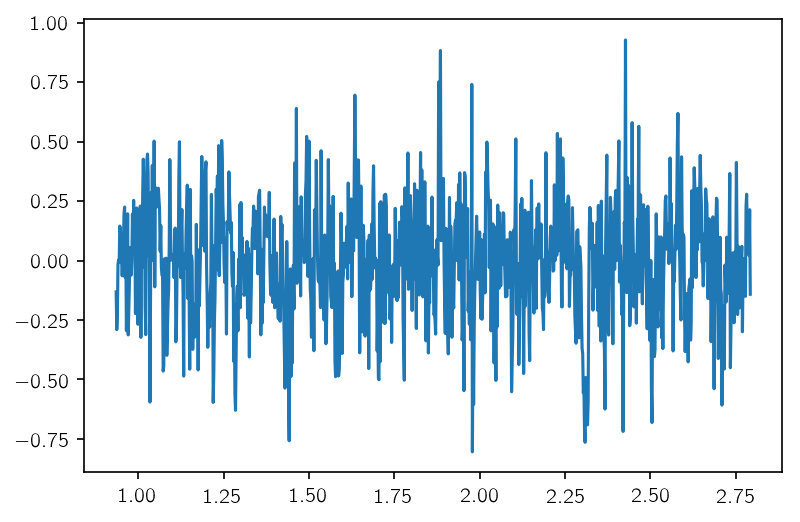

In [76]:
data = np.loadtxt('211351816.dat.ts')

m = np.all(np.isfinite(data), axis=1)
m &= np.arange(len(data)) > 500
m &= np.arange(len(data)) < 1500

t = data[m, 0]*0.0864
y = data[m, 1]*1e3
yerr = np.median(np.abs(np.diff(y)))
log_var = np.log(np.var(y))
print(yerr)

plt.plot(t, y);

In [77]:
# These functions are used to transform bounded parameters to parameters to parameters with infinite range
def get_param_for_value(value, min_value, max_value):
    if np.any(value <= min_value) or np.any(value >= max_value):
        raise ValueError("value must be in the range (min_value, max_value)")
    return np.log(value - min_value) - np.log(max_value - value)

def get_value_for_param(param, min_value, max_value):
    return min_value + (max_value - min_value) / (1.0 + np.exp(-param))

def get_bounded_variable(name, value, min_value, max_value, dtype=tf.float64):
    param = tf.Variable(get_param_for_value(value, min_value, max_value), dtype=dtype, name=name + "_param")
    var = min_value + (max_value - min_value) / (1.0 + tf.exp(-param))
    log_jacobian = tf.log(var - min_value) + tf.log(max_value - var) - np.log(max_value - min_value)
    return param, var, tf.reduce_sum(log_jacobian), (min_value, max_value)

# This function constrains a pair of parameters to be a unit vector
def get_unit_vector(name, x_value, y_value, dtype=tf.float64):
    x_param = tf.Variable(x_value, dtype=dtype, name=name + "_x_param")
    y_param = tf.Variable(y_value, dtype=dtype, name=name + "_y_param")
    norm = tf.square(x_param) + tf.square(y_param)
    log_jacobian = -0.5*tf.reduce_sum(norm)
    norm = tf.sqrt(norm)
    x = x_param / norm
    y = y_param / norm
    return x_param, y_param, x, y, log_jacobian

In [78]:
np.random.seed(42)

T = tf.float64

log_prior = tf.constant(0.0, dtype=T)
nl = 3
nn = 3
nmodes = (2*nn+1)*nl

# The peak power is a nu_max
log_numax_param, log_numax, log_jac, log_numax_range = get_bounded_variable("log_numax", np.log(220.0), np.log(150.0), np.log(300.0), dtype=T)
log_prior += log_jac

# The highest frequency for mode l is at nu_max_l
log_numax_l_param, log_numax_l, log_jac, log_numax_l_range = get_bounded_variable("log_numax_l", np.log(220.0) + np.zeros(nl), np.log(150.0), np.log(300.0), dtype=T)
log_prior += log_jac

# Frequency spacing
log_dnu_param, log_dnu, log_jac, log_dnu_range = get_bounded_variable("log_dnu", np.log(17.0), np.log(15.0), np.log(30.0), dtype=T)
log_prior += log_jac

# The phase for each mode
cp, sp = np.random.randn(2, nmodes)
phi_x, phi_y, cosphi, sinphi, log_jac = get_unit_vector("phi", cp, sp, dtype=T)
log_prior += log_jac
phi = tf.atan2(sinphi, cosphi)

# The parameters of the envelope
log_amp_param, log_amp, log_jac, log_amp_range = get_bounded_variable("log_amp", log_var + np.zeros(nl), log_var - 2.0, log_var + 2.0, dtype=T)
log_prior += log_jac
log_width = tf.Variable(np.log(25.0), dtype=T, name="log_width")
curve = tf.Variable(0.001 + np.zeros(nl), dtype=T, name="curve")

# Define the frequency comb
dn = np.arange(-nn, nn+1)
l = np.arange(nl)
numax = tf.exp(log_numax)
numax_l = tf.exp(log_numax_l)
dnu = tf.exp(log_dnu)
nu = (numax_l + 0.5*l*dnu)[:, None] + dnu*(dn[None, :] + curve[:, None]*(dn**2)[None, :])
amp = tf.exp(log_amp[:, None]-0.5*(nu - numax)**2 * tf.exp(-2*log_width))

# The echelle diagram
echelle = [tf.transpose(tf.mod(nu, dnu)), tf.transpose(nu)]

# Define the model
amp_flat = tf.reshape(amp, (-1,))
nu_flat = tf.reshape(nu, (-1,))
phi_flat = tf.reshape(phi, (-1,))
models = amp_flat[None, :] * tf.sin(2*np.pi*nu_flat[None, :]*t[:, None] + phi_flat[None, :])

model_y = tf.reduce_sum(models, axis=1)

# Compute the approximate marginalized likelihood
arg = 2 * np.pi * nu_flat[None, :] * t[:, None]
A = tf.concat([tf.cos(arg), tf.sin(arg), tf.ones((len(t), 1), dtype=T)], axis=1)
w = tf.linalg.solve(tf.matmul(A, A, transpose_a=True), tf.matmul(A, y[:, None], transpose_a=True))
resid = y - tf.squeeze(tf.matmul(A, w))
marg_like = -0.5*tf.reduce_sum(tf.square(resid))

# Granulation
# nada = tf.constant([], dtype=T)
# log_S0 = tf.Variable(np.log([0.1, 0.05]), dtype=T, name="log_S0")
# log_w0 = tf.Variable(2*np.pi*np.log([0.1, 1e-5]), dtype=T, name="log_w0")
# a = tf.exp(log_S0 + log_w0)
# c = 0.5 * tf.exp(log_w0)

# Initialize
session.run(tf.global_variables_initializer())

# Simulate data from the real model
# y = session.run(model_y) + yerr * np.random.randn(len(t))

# Compute the GP likelihood
# resid = (y - model_y)[:, None]

# A, U, V, P = ops.get_celerite_matrices(nada, nada, a, a, c, c, t, yerr**2)
# D, W = ops.celerite_factor(A, U, V, P)
# z = ops.celerite_solve(U, P, D, W, resid)

# chi2 = tf.squeeze(tf.matmul(resid, z, transpose_a=True)) + tf.reduce_sum(tf.log(D))
# log_like -= 0.5*chi2

log_like = -0.5*tf.reduce_sum(tf.square((y - model_y)/yerr))

var_list = [log_numax_param, log_dnu_param, log_numax_l_param, log_amp_param, log_width, curve, phi_x, phi_y]

log_prob = log_prior + log_like
grad = tf.gradients(log_prob, var_list)

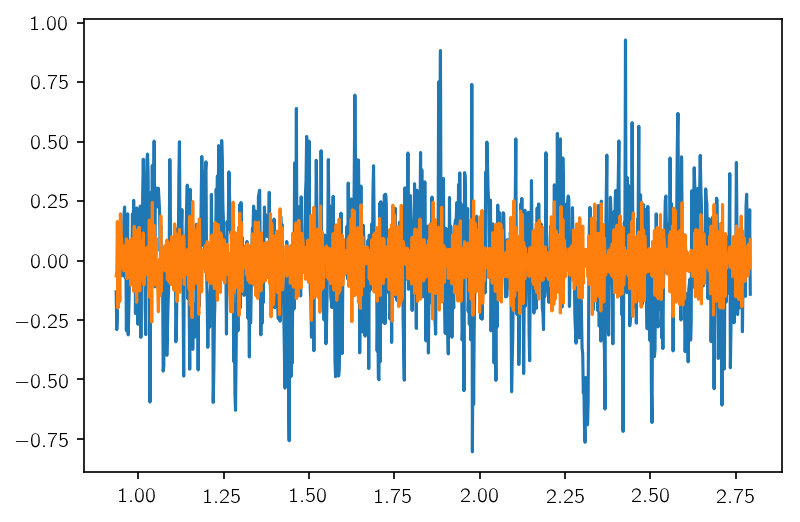

In [79]:
plt.plot(t, y)
plt.plot(t, session.run(model_y))

In [80]:
%timeit session.run(log_prob)

The slowest run took 230.70 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 1.01 ms per loop


In [81]:
%timeit session.run(grad)

The slowest run took 136.71 times longer than the fastest. This could mean that an intermediate result is being cached.
1 loop, best of 3: 2.02 ms per loop


In [82]:
numax_values = session.run(numax + dnu * np.linspace(-0.5, 0.5, 50))
dnu_values = session.run(dnu * np.linspace(0.9, 1.1, 201))
results = np.empty((len(numax_values), len(dnu_values)))
for n, v1 in enumerate(numax_values):
    for m, v2 in enumerate(dnu_values):
        fd = {numax_l: v1+np.zeros(nl), dnu: v2}
        results[n, m] = session.run(marg_like, feed_dict=fd)

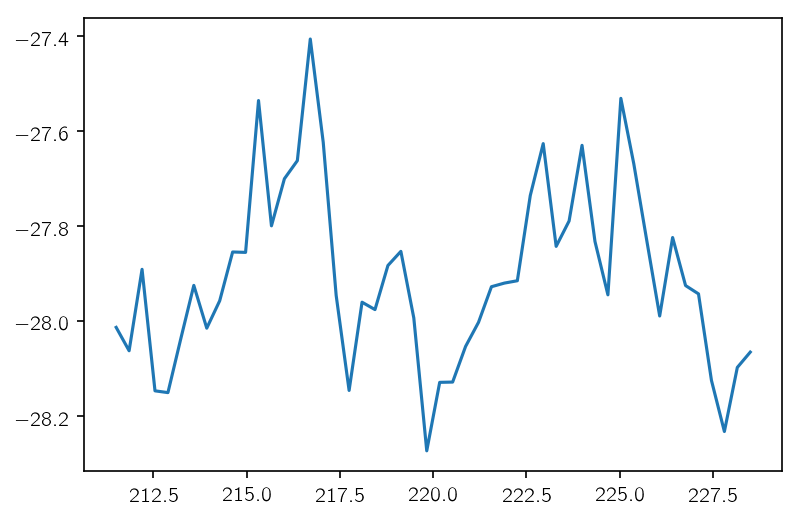

In [83]:
plt.plot(numax_values, np.max(results, axis=1));

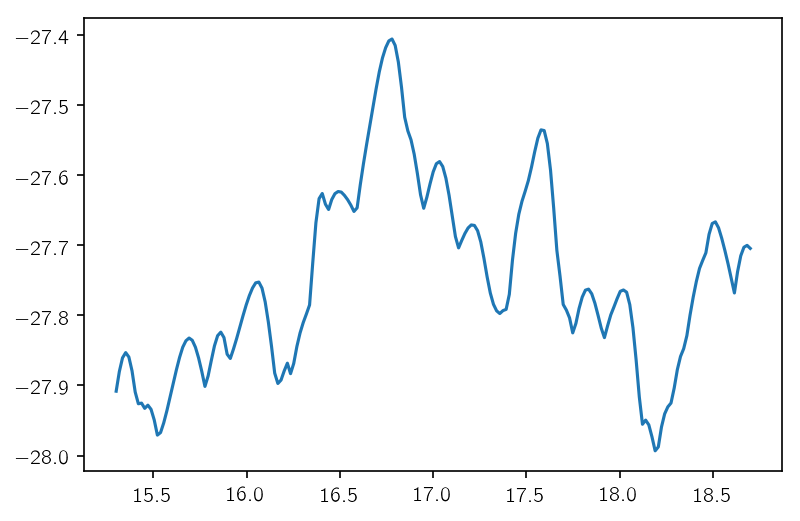

In [84]:
plt.plot(dnu_values, np.max(results, axis=0));

In [85]:
inds = np.unravel_index(np.argmax(results), results.shape)
param = get_param_for_value(np.log(dnu_values[inds[1]]), *log_dnu_range)
session.run(tf.assign(log_dnu_param, param))
param = get_param_for_value(np.log(numax_values[inds[0]]), *log_numax_l_range)
session.run(tf.assign(log_numax_l_param, param + np.zeros(nl)))

array([0.12321094, 0.12321094, 0.12321094])

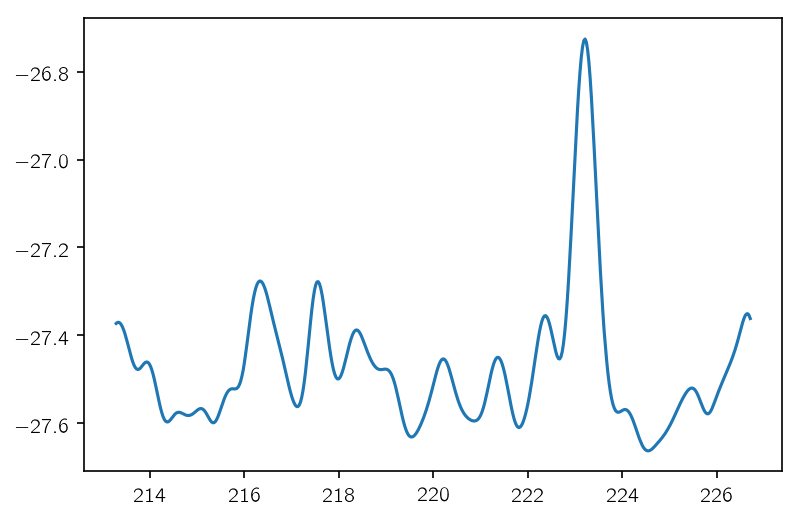

In [86]:
if nl > 2:
    numax_2_values = session.run(numax + dnu * np.linspace(-0.4, 0.4, 500))
    nml = session.run(numax_l)
    results_2 = np.empty(len(numax_2_values))
    for n, v1 in enumerate(numax_2_values):
        nml[2] = v1
        fd = {numax_l: nml}
        results_2[n] = session.run(marg_like, feed_dict=fd)
    plt.plot(numax_2_values, results_2)
    ind = np.argmax(results_2)
    nml[2] = numax_2_values[ind]
    param = get_param_for_value(np.log(nml), *log_numax_l_range)
    session.run(tf.assign(log_numax_l_param, param))

In [88]:
neg_log_prob = -log_prob

for i in range(3):
    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[phi_x, phi_y])
    opt.minimize(session)

    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_amp_param])
    opt.minimize(session)

    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[log_width])
    opt.minimize(session)

    opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=[curve])
    opt.minimize(session)

opt = tf.contrib.opt.ScipyOptimizerInterface(neg_log_prob, var_list=var_list)
opt.minimize(session)

INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 960.858206
  Number of iterations: 29
  Number of functions evaluations: 107
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 915.888005
  Number of iterations: 7
  Number of functions evaluations: 8
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 914.735677
  Number of iterations: 3
  Number of functions evaluations: 5
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 914.504323
  Number of iterations: 5
  Number of functions evaluations: 12
INFO:tensorflow:Optimization terminated with:
  Message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
  Objective function value: 910.456679
  Number 

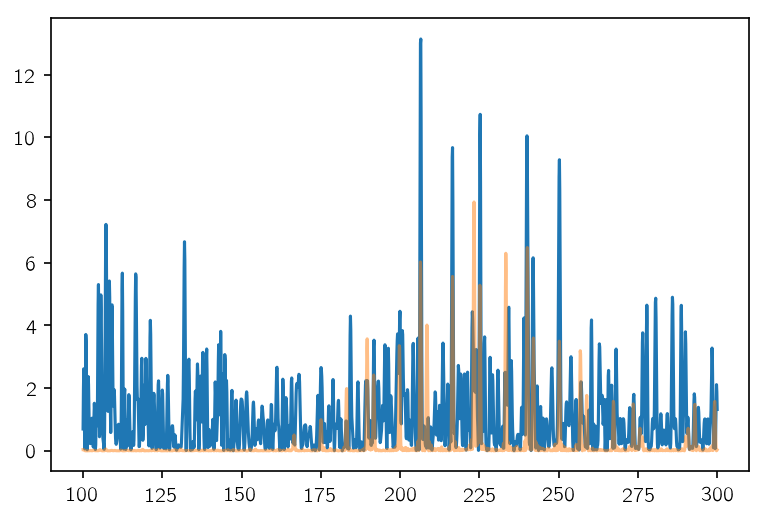

In [89]:
m = LombScargle(t, y, yerr)
f, p = m.autopower(minimum_frequency=100, maximum_frequency=300, nyquist_factor=100, normalization="psd")
plt.plot(f, p);

m = LombScargle(t, session.run(model_y), yerr)
f, p = m.autopower(minimum_frequency=100, maximum_frequency=300, nyquist_factor=100, normalization="psd")
plt.plot(f, p, alpha=0.5);

In [90]:
from helpers import TFModel
model = TFModel(log_prob, var_list)
model.setup(session)

In [91]:
# We'll use the inverse Hessian to estimate the initial scales of the problem
hess = session.run(tf.hessians(log_prob, var_list))
var = 1.0 / np.abs(np.concatenate([np.diag(np.atleast_2d(h)) for h in hess]))
# var = np.ones_like(model.current_vector())

In [66]:
import hemcee

metric = hemcee.metric.DenseMetric(np.diag(var))

sampler = hemcee.NoUTurnSampler(model.value, model.gradient, metric=metric)

q, lp = sampler.run_warmup(model.current_vector(), 2000)

initial warm up: step_size: 5.7e-01; mean(accept_stat): 0.497: 100%|██████████| 100/100 [00:10<00:00,  8.36it/s]
warm up 1/7: step_size: 4.9e-01; mean(accept_stat): 0.487: 100%|██████████| 25/25 [00:02<00:00,  7.70it/s]
warm up 2/7: step_size: 3.5e-02; mean(accept_stat): 0.467: 100%|██████████| 25/25 [00:02<00:00,  8.95it/s]
warm up 3/7: step_size: 2.5e-02; mean(accept_stat): 0.474: 100%|██████████| 50/50 [00:04<00:00,  9.54it/s]
warm up 4/7: step_size: 4.5e-02; mean(accept_stat): 0.485: 100%|██████████| 100/100 [00:10<00:00,  9.75it/s]
warm up 5/7: step_size: 9.2e-02; mean(accept_stat): 0.487: 100%|██████████| 200/200 [00:22<00:00,  9.32it/s]
warm up 6/7: step_size: 1.8e-01; mean(accept_stat): 0.493: 100%|██████████| 400/400 [00:39<00:00,  9.82it/s]
warm up 7/7: step_size: 1.3e-01; mean(accept_stat): 0.495: 100%|██████████| 1000/1000 [01:40<00:00,  9.98it/s]
final warm up: step_size: 2.7e-02; mean(accept_stat): 0.481: 100%|██████████| 100/100 [00:09<00:00, 10.21it/s]


In [67]:
nuts = sampler.run_mcmc(q, 2000)

step_size: 2.2e-02; mean(accept_stat): 0.508: 100%|██████████| 2000/2000 [03:18<00:00, 10.31it/s]


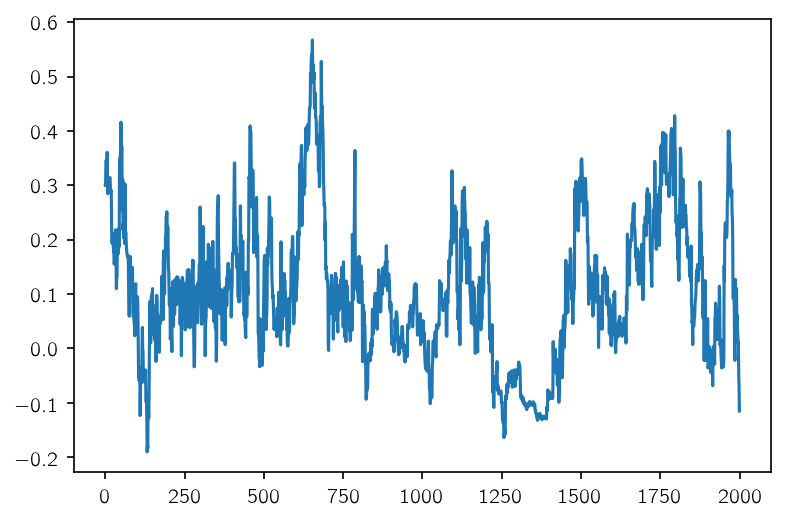

In [68]:
plt.plot(nuts[0][:, 0]);

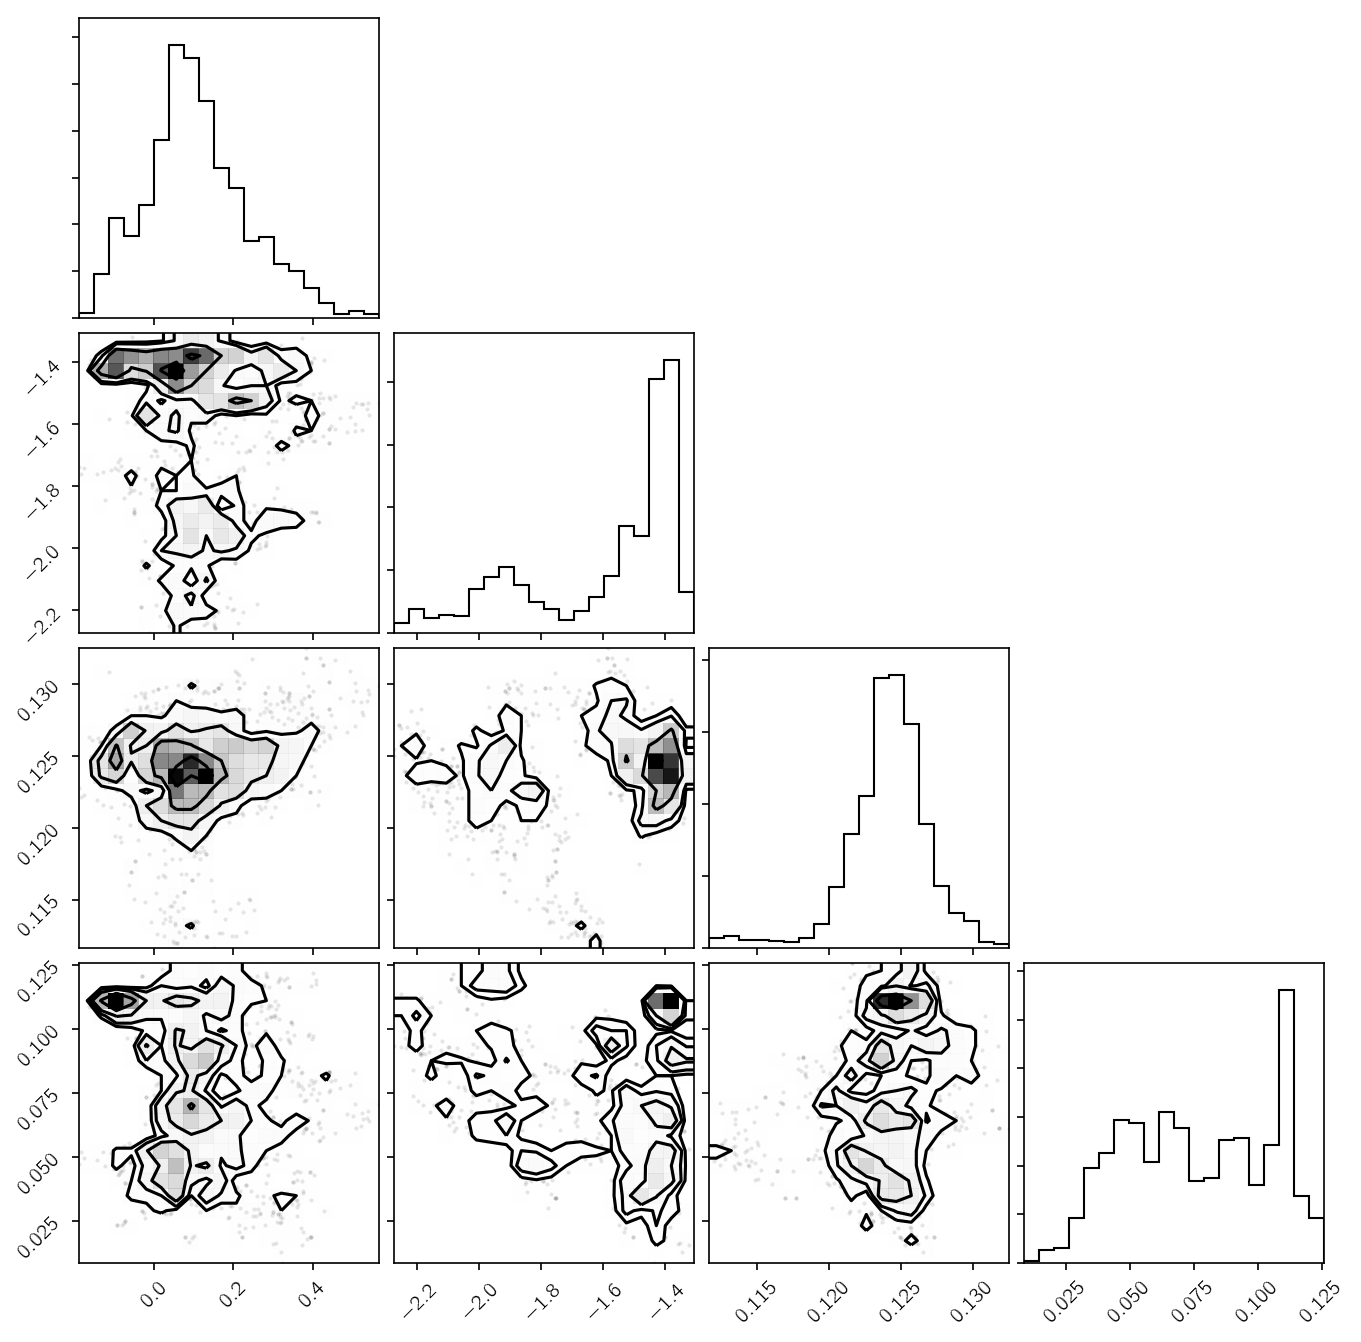

In [69]:
import corner
corner.corner(nuts[0][:, :4]);

In [70]:
chain = nuts[0]

In [71]:
# from emcee.autocorr import integrated_time
# tau_nuts = integrated_time(chain[:, None, :])
# neff_nuts = len(chain) / np.mean(tau_nuts)
# tau_nuts, neff_nuts

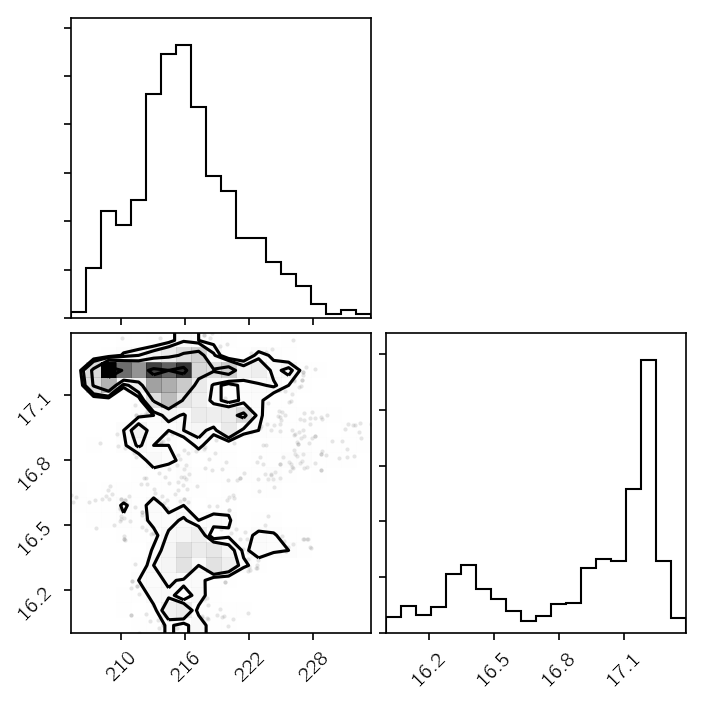

In [72]:
nu_max_value = np.exp(get_value_for_param(nuts[0][:, 0], *log_numax_range))
dnu_value = np.exp(get_value_for_param(nuts[0][:, 1], *log_dnu_range))

corner.corner(np.vstack((nu_max_value, dnu_value)).T);

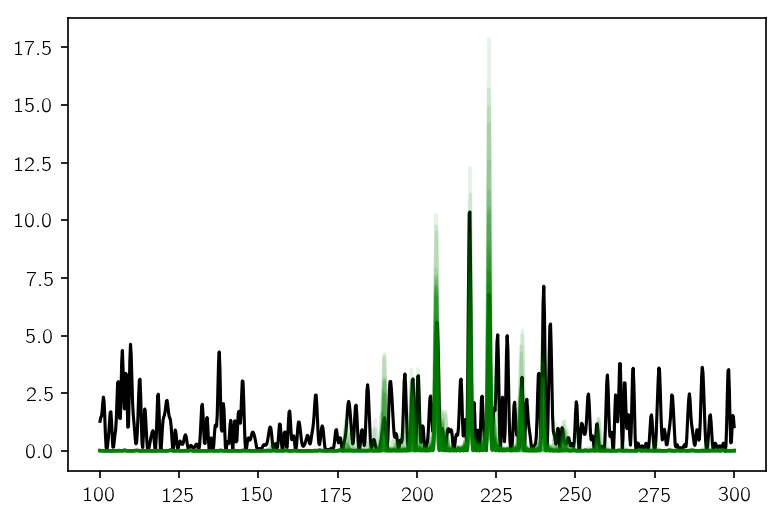

In [73]:
m = LombScargle(t, y, yerr)
f, p = m.autopower(minimum_frequency=100, maximum_frequency=300, nyquist_factor=100, normalization="psd")
plt.plot(f, p, "k");

chain = nuts[0]

for i in np.random.randint(len(chain), size=50):
    s = chain[i]
    m = LombScargle(t, session.run(model_y, feed_dict=model.vector_to_feed_dict(s)), yerr)
    f, p = m.autopower(minimum_frequency=100, maximum_frequency=300, nyquist_factor=100, normalization="psd")
    plt.plot(f, p, "g", alpha=0.1);

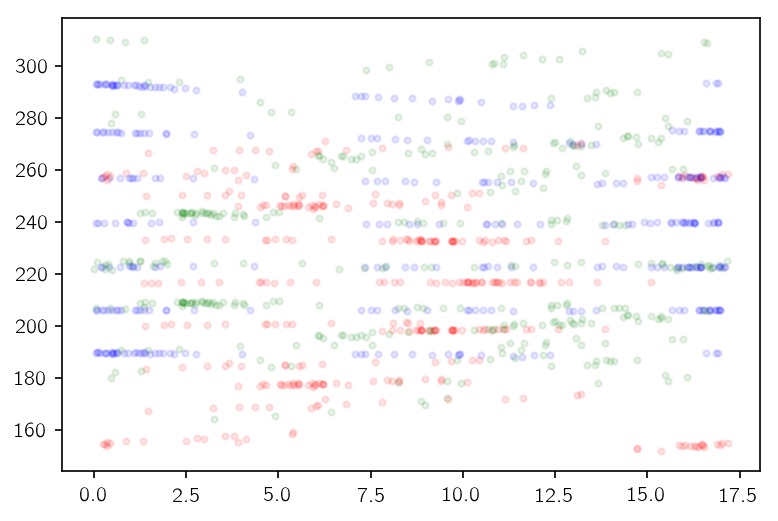

In [74]:
for i in np.random.randint(len(chain), size=50):
    s = chain[i]
    a, b = session.run(echelle, feed_dict=model.vector_to_feed_dict(s))
    for l, c in enumerate("rgb"):
        plt.plot(a[:, l], b[:, l], ".", color=c, alpha=0.1)
